# Use hh2 dataset to train a maching learning model

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

Import Dataset and remove variables where outcome is a nonstarter

In [2]:
hh = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Data_Wrangling/hh2.csv")

In [3]:
hh.shape

(70203, 33)

In [4]:
hh = hh[hh.unbanked >= 0]

In [5]:
hh = hh.dropna()

Identify all variables of interest for the testing:

In [6]:
#Unbanked, Children under 15, Previous bank usage, income, family type, age, unemployment, citizenship, immigrant status,race, income volitility, and internet access
hh_small = hh[["unbanked","bank_prev","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"]].copy()
#removed to dummy:
#"hagele15","hhtype","hhincome","prtage"
#needs education dummy

Split the data by X and Y and prepare training sample

In [7]:
y = hh["unbanked"]
X = hh[["unbanked","bank_prev","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"]]

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.1,random_state=1999)

In [9]:
# Let's 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [10]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,unbanked,bank_prev,poverty,under_25,unemployed,citizen,native_born,White_or_AAPI,inc_vol,internet,children,single_mother
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
16348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16349,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
16350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [11]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["unbanked","bank_prev","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['unbanked',
                                                                          'bank_prev',
                                                                          'poverty',
                                                                          'under_25',
                                                                          'unemployed',
                                                                          'citizen',
                                                                          'native_born',
                                                                          'White_or_AAPI',
            

In [12]:
search.best_score_

0.0

In [13]:
search.best_params_

{'model': DecisionTreeRegressor(max_depth=1), 'model__max_depth': 1}

In [14]:
pred_y = search.predict(test_X)

In [15]:
m.mean_squared_error(test_y,pred_y)

0.0

In [16]:
m.r2_score(test_y,pred_y)

1.0

In [17]:
m.accuracy_score(test_y,pred_y)

1.0

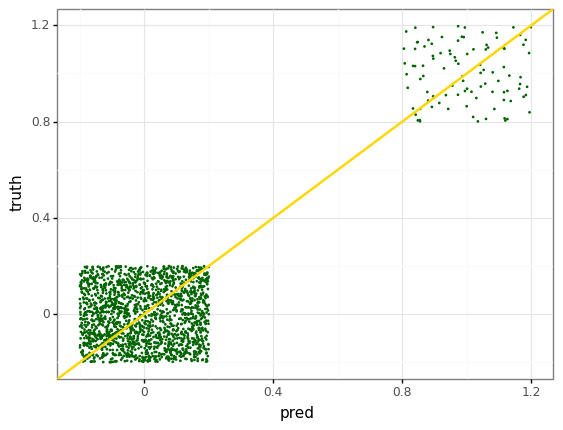

<ggplot: (8773081450421)>

In [18]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_jitter(color="darkgreen", size=.1, width = 0.2, height = 0.2) +
    geom_abline(color="gold",size=1) +
    theme_bw() 
)

Run Decision Tree Seperately since it's the best model

In [19]:
m.confusion_matrix(test_y,pred_y)

array([[1718,    0],
       [   0,   99]])

In [20]:
import seaborn as sns

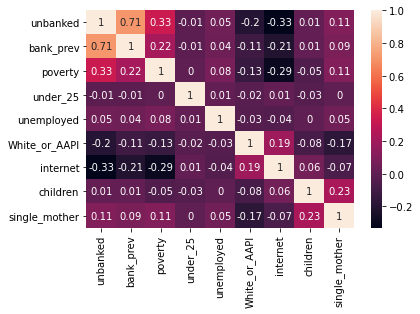

In [21]:
correlation_mat = hh_small.corr()
correlation_mat = correlation_mat.round(decimals = 2)
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [22]:
np.savetxt("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Slides/graph_data/test_bi", test_y, delimiter=",")
np.savetxt("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Slides/graph_data/pred_bi", pred_y, delimiter=",")
np.savetxt("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Slides/graph_data/corr", correlation_mat, delimiter=",")